In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import re
import os

fileprefix = "data/arab_1_1"
json_file = f"{fileprefix}_metadata.json"
data_file = f"{fileprefix}.csv"
df = pd.read_csv(data_file)
df.rename(columns={"time": "time_s"}, inplace=True)
print(df.head())

def pretty_print_metadata(metadata):
    print("Metadata:")
    for key, value in metadata.items():
        if key != "event_logger":
            print(f"{key}: {value}")


def pretty_print_events(event_logger_json):
    for event in event_logger_json:
        print(f"  {event['time_s']}: {event['label']}")


with open(json_file, "r") as f:
    metadata = json.load(f)
    # pretty_print_metadata(metadata)
    # pretty_print_events(metadata["event_logger"])


def get_event_logger_time_for_event(event_name_pattern, metadata):
    """
    Search for a time_s of the first event whose label matches the given pattern (case-insensitive, substring match).
    """
    pattern = re.compile(event_name_pattern, re.IGNORECASE)
    for event in metadata["event_logger"]:
        if pattern.search(event["label"]):
            return event["time_s"]
    return None


# we expect the difference between the time_s of the event "ared_on_for_2.000_seconds" and "action_ared_off_executed_at_0.000_s" to be equal to the metadata["ared_duration_s"]
ared_on_time = get_event_logger_time_for_event("ared_on", metadata)
ared_off_time = get_event_logger_time_for_event("ared_off", metadata)
ared_duration = metadata["ared_duration_s"]

# Don't use assert, but log the errors in a list and then print them out at the end
errors = []
# Green LED timing verification
agreen_on_time = get_event_logger_time_for_event("agreen_on", metadata)
agreen_off_time = get_event_logger_time_for_event("agreen_off", metadata)
agreen_duration = metadata.get("agreen_duration_s")

print(
    f"agreen_on_time: {agreen_on_time}, agreen_off_time: {agreen_off_time}, agreen_duration: {agreen_duration}"
)

if (
    agreen_on_time is not None
    and agreen_off_time is not None
    and agreen_duration is not None
):
    actual_duration = agreen_off_time - agreen_on_time
    if abs(actual_duration - agreen_duration) > 0.01:
        errors.append(
            f"Agreen LED duration mismatch: expected {agreen_duration}s, got {actual_duration:.3f}s"
        )

# ARED timing verification (moved here from above to match structure)
if ared_on_time is not None and ared_off_time is not None and ared_duration is not None:
    actual_duration = ared_off_time - ared_on_time
    if abs(actual_duration - ared_duration) > 0.01:
        errors.append(
            f"Ared LED duration mismatch: expected {ared_duration}s, got {actual_duration:.3f}s"
        )

# Sample count check
expected_duration = metadata.get("recording_length_s")
hz = metadata.get("recording_hz")
acquired_event_time = get_event_logger_time_for_event(
    "acquired_", metadata
)  # partial match

if expected_duration is not None and hz is not None:
    expected_samples = int(round(expected_duration * hz))
    print(f"Expected samples: {expected_samples}")

    # Look for the line like: "acquired_2003_samples_in_2.010_seconds"
    acquired_event = next(
        (e for e in metadata["event_logger"] if "acquired_" in e["label"]), None
    )
    if acquired_event:
        match = re.search(
            r"acquired_(\d+)_samples_in_([\d.]+)_seconds", acquired_event["label"]
        )
        if match:
            acquired_samples = int(match.group(1))
            if abs(acquired_samples - expected_samples) > 2:
                errors.append(
                    f"Sample count mismatch: expected ~{expected_samples}, got {acquired_samples}"
                )
        else:
            errors.append("Could not parse acquired samples line.")
    else:
        errors.append("No acquired_...samples... event found")

# Print summary
if errors:
    print("\n--- Validation Errors ---")
    for err in errors:
        print(" -", err)
else:
    print("\nAll metadata timing checks passed.")

   time_s    signal
0  0.0000  2.821368
1  0.0005  2.846142
2  0.0010  2.800133
3  0.0015  2.814290
4  0.0020  2.810751
agreen_on_time: 1.52047, agreen_off_time: 4.520411, agreen_duration: 3.0

All metadata timing checks passed.


In [6]:
# print all of the metadata
pretty_print_metadata(metadata)
pretty_print_events(metadata["event_logger"])

Metadata:
actinic_led_intensity: 40
measurement_led_intensity: 40
recording_hz: 2000
ared_duration_s: 0.5
wait_after_ared_s: 0.0
agreen_delay_s: 0.0
agreen_duration_s: 3.0
channel_range: 50
filename: C:\repos\FLuorInduc\data\arab_1_1.csv
action_epsilon_s: 0.001
  0.0: protocol_start
  0.003746: total_recording_length: 3.600 seconds
  0.003747: recording_hz: 2000
  0.003748: n_samples_calculated: 7200
  0.003749: creating_timed_action_factory
  0.003769: preparing_recorder
  0.00377: setup_recording
  0.004579: recorder_prepared
  0.004693: start_buffer_flush
  1.009014: data_available_at_sample_4
  1.009028: recording_loop_started_at_246949.749452
  1.016159: action_ared_on_executed (scheduled=+0.000s)
  1.01617: t_zero_initialized_from_actual_ared_on_at_+1.011071_s
  1.518754: action_ared_off_executed (scheduled=+0.500s)
  1.518944: action_shutter_opened_executed (scheduled=+0.500s)
  1.52047: action_agreen_on_executed (scheduled=+0.500s, actual=+0.504s, latency=0.004s)
  4.520411: ac

```
4.520411: action_agreen_off_executed (scheduled=+3.500s, actual=+3.504s, latency=0.004s)
4.541062: action_end_recording_executed (scheduled=+3.525s, actual=+3.525s, latency=-0.000s)
4.541075: recording_completed
```

I have a suspicion that this is the period where the signal drops precipitously. But its time axis is actually the time axis of recording, so it should be around 2 seconds shifted to the left.

So lets shift the time_series by 2 seconds to the left, and then plot it again.




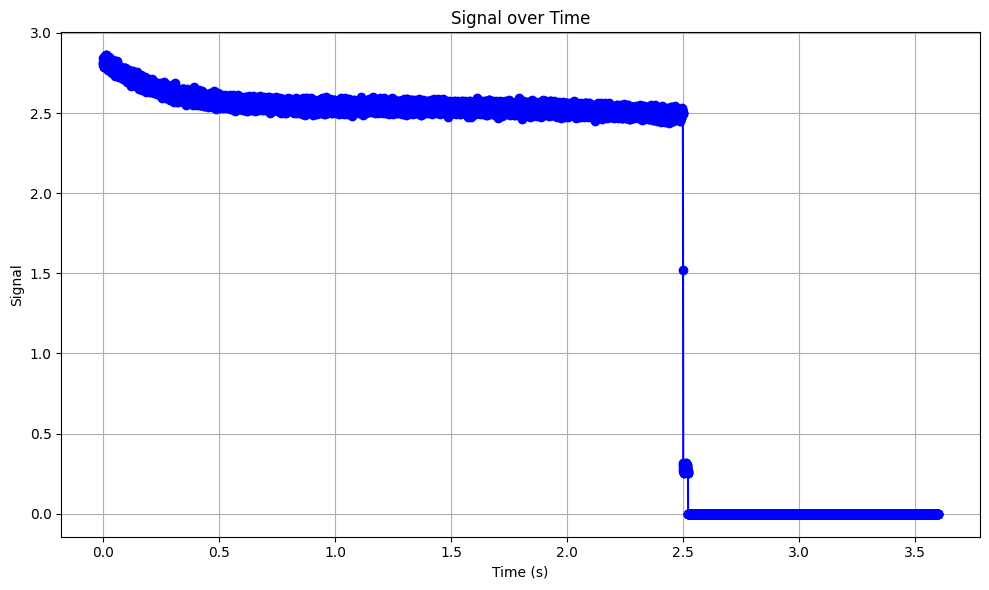

In [ ]:
import numpy as np

# did we lose like the first 1 second of data?
    
t_1 = 4.520411 - 1
t_2 = 4.541062 - 1
t_end_recording = 4.541075 - 1

df_shifted = df.copy()
# df_shifted["time_s"] = df_shifted["time_s"] - 2.4

# plot the data
plt.figure(figsize=(10, 6))
plt.plot(
    df_shifted["time_s"], df_shifted["signal"], marker="o", linestyle="-", color="b"
)
plt.title("Signal over Time")
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.grid(True)
plt.tight_layout()
plt.show()